# Train A Face Mask Classifier
The dataset used here has been referenced from [this link](https://drive.google.com/drive/folders/1XDte2DL2Mf_hw4NsmGst7QtYoU7sMBVG?usp=sharing). The model is trained on Google Colaboratory with free GPU. Author of this dataset has used concept of transfer learning but i am using my own custom CNN model because this custom model has less parameters and works fast while predicting.

## Prepare DL Library
Before begining our training, make sure to download the right version of Keras and Tensorflow. I am using below versions because these are installed on my system. Keras often requires the same version while training the model and reusing the model later on.
**Make sure you are running on the GPU. If GPU is not available then you can download saved model from [this link.](https://github.com/q-viper/Face-Mask-Detection-Deployment)**

In [1]:
!pip install keras==2.2.4
!pip install tensorflow==1.15.0

## Mount the Drive 
In order to use the files/contents we have under our drive, we have to mount it.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The drive can now be accessed just like our local drive. Lets locate where our files are. For me, i made a folder named **Mask Detection** and then inside there, copied the [dataset provided](https://drive.google.com/drive/folders/1XDte2DL2Mf_hw4NsmGst7QtYoU7sMBVG?usp=sharing).

In [3]:
data_dir="/content/drive/My Drive/Face Mask Detection/dataset"
# nomask="/content/drive/My Drive/dataset/without_mask"

## Import Dependencies
Some of the classes imported here (from `tensorflow.keras.layers`) are not used and they were provided just for experimentation. 

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

## Prepare Dataset
One of the most useful way of data preparation is using Data Generator. It uses the generator function under the hood to provide iterator and it also helps us preserve the memory. **How?** Datagenerators are supposed to read image files only on the runtime and we can really save our memory by saving only the data of current batch. Along with Datagenerator, we can pass some arguments like target size of image.

I recommend you to experiment with different target sizes. But beware of the Colab Usages because it suspends for 12 hours sometimes. Larger the image size, more the computation requires. Large the image size, more the information but requires more memory. Hence choose it wisely. 

Using augmentation can help us generate different variations of training images. But using some arguments below, we are performing some level of augmentation also. Keras has Image Agumentation Class also.

Since we don't have testing dataset, Keras provides us a way of using some part of training dataset as testing too. Since our data is categorical, we will use class_mode too. We are using batch_size as 32. There is not a universal value of batch_size as 32 but it is popular though. 

While reading image, we also are rescaling it to 0 to 1 from 0 to 255. Doing this will ease us with lower computation, loss and performance also.

In [15]:
# hyper parameters
batch_size = 32
img_height, img_width=64,64
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 3067 images belonging to 2 classes.
Found 766 images belonging to 2 classes.


How many of images are total? How many of batches will there be?

\begin{equation}
batches=\frac{totalImages}{batchSize}
\end{equation}


In [16]:
print(f"Training Images: {len(train_generator)*batch_size}\nTesting Images: {len(validation_generator)*batch_size}")

Training Images: 3072
Testing Images: 768


## Model Creation
What type of model should be used? what will be the input shape? What will be the activation function?
Model we are using is CNN. Its input shape should be equal to the shape of iamge. Activation function is mostly used ReLU because of its non linearity and finely working with images.

The concept of CNN can be thought as belows:
* Take an image of certain shape, take a lens.
* Scan the image by lens and once we knew certain things about images, draw the another image seen from lens, then try with another lens on same image and repeat for all other lens of this level.
* Finally, take the new images from previous layer and then use new lenses and perform operations like on previous step.
* If there are not that useful details seen, then take a lens that minimizes the shape of images. Then look over the newly made images on previous step.
* Repeat aboves processes for some time until our image becomes very small.

The output shape of Convolution layer will be

\begin{equation}
w = \frac{W-f + 2p}{s} + 1
\end{equation}

* Where 𝑊 is input shape.
* 𝑓 is filter shape.
* 𝑝 is padding.
* 𝑠 is stride.

In [17]:

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (img_height, img_width, 3), activation = 'relu', data_format = 'channels_last'))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(3, 3)))
# model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 41, 41, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 39, 39, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21632)            

## Train it!
Before training, we need to compile our model. We will provide optimizer and loss function to see tune our model. Also we can use metrics like accuracy, MAE, MSE etc.

For optimizer, we are using ADAM.

In [18]:
lr=1e-04
epochs=30

opt = Adam(lr=lr, decay=lr / epochs)

# compile it !
model.compile(loss="binary_crossentropy", optimizer=opt,	metrics=["accuracy"])

# train it
history=model.fit_generator(
	train_generator,
	steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
	validation_steps=len(validation_generator),
	epochs=epochs,
  verbose=1)

Epoch 1/30
23/96 [======>.......................] - ETA: 23s - loss: 0.5884 - acc: 0.6889

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


96/96 [==============================] - 35s 368ms/step - loss: 0.3451 - acc: 0.8513 - val_loss: 0.1810 - val_acc: 0.9439
Epoch 2/30
96/96 [==============================] - 32s 332ms/step - loss: 0.2123 - acc: 0.9224 - val_loss: 0.1585 - val_acc: 0.9452
Epoch 3/30
96/96 [==============================] - 32s 333ms/step - loss: 0.1758 - acc: 0.9348 - val_loss: 0.1226 - val_acc: 0.9634
Epoch 4/30
96/96 [==============================] - 31s 324ms/step - loss: 0.1593 - acc: 0.9364 - val_loss: 0.1200 - val_acc: 0.9556
Epoch 5/30
96/96 [==============================] - 32s 333ms/step - loss: 0.1490 - acc: 0.9436 - val_loss: 0.1125 - val_acc: 0.9634
Epoch 6/30
96/96 [==============================] - 33s 345ms/step - loss: 0.1387 - acc: 0.9498 - val_loss: 0.1036 - val_acc: 0.9674
Epoch 7/30
96/96 [==============================] - 32s 329ms/step - loss: 0.1275 - acc: 0.9498 - val_loss: 0.0942 - val_acc: 0.9687
Epoch 8/30
96/96 [==============================] - 32s 331ms/step - loss: 0.114

## How well model performed?
The model's validation and training accuracy was 98% by the end of 30 epoch. But we can use model's training object to visualize metrics. 
> Using accuracy alone won't be good to describe the model's performance. Metrics like F1 score, confusion matriz are best for categorical data.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


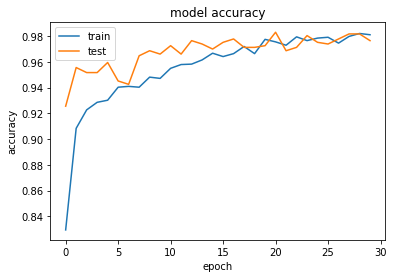

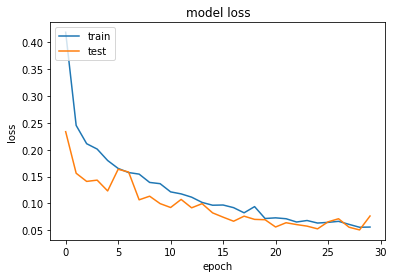

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Try it on some examples.

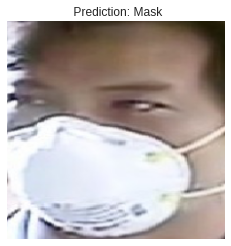

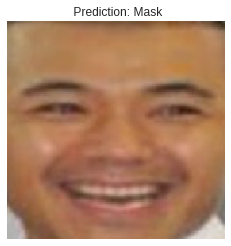

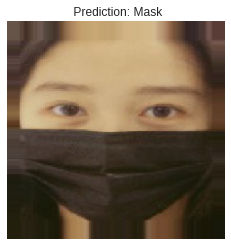

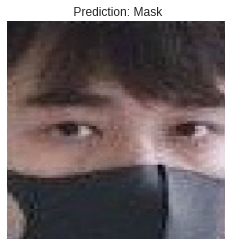

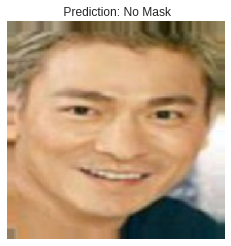

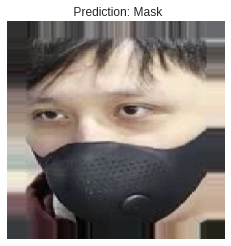

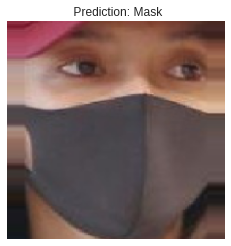

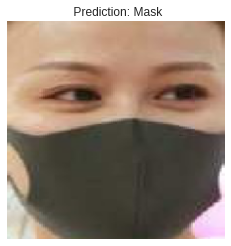

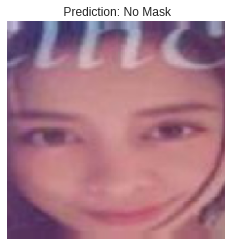

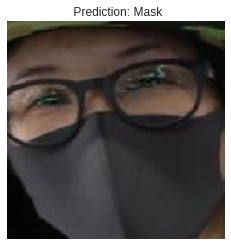

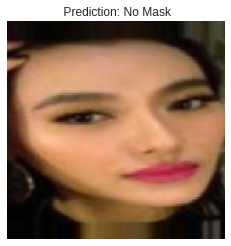

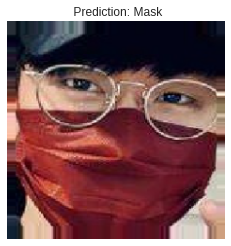

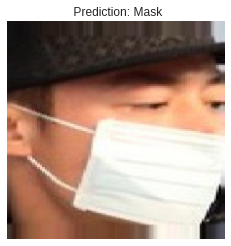

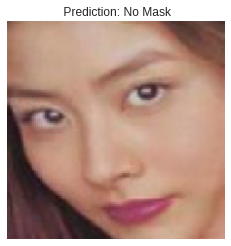

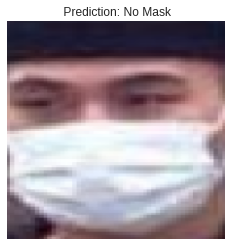

In [ ]:
import cv2
plt.style.use('seaborn-whitegrid')
for i in range(15):
    img = validation_generator[0][0][i]
    img = cv2.resize(img, (img_height, img_width))
    img = img.reshape(1, img_height, img_width, 3)
#     lbl = np.argmax(y_test[i])
    prediction = model.predict(img)
#     print(prediction)
    prediction = np.argmax(prediction)
#     print(prediction, lbl)
    classes = ["Mask", "No Mask"]
    title = f" Prediction: {classes[prediction]}"
    plt.imshow(img.reshape(img_height, img_width, 3))
    plt.title(title)
    plt.axis("off")
    plt.show()

## Save it!
In order to use our trained model on Flask APP, save it and then download it.

In [19]:
# Lets save our model 
model.save("customCNN128.h5")

## What type of features is each layer learning?
The result below is of the features of model while it was MobileNet. I have not run below cell.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


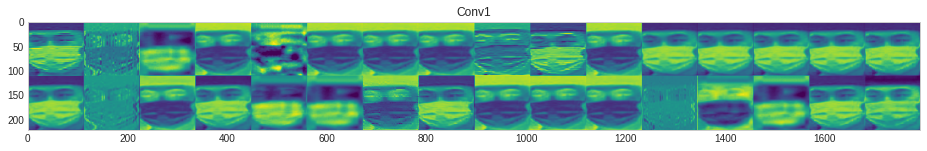

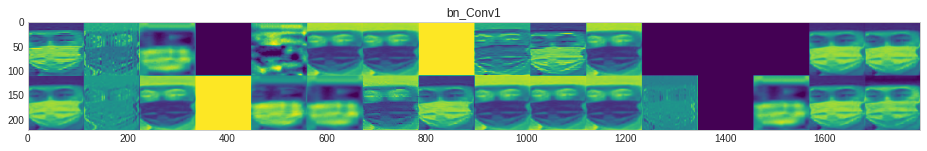

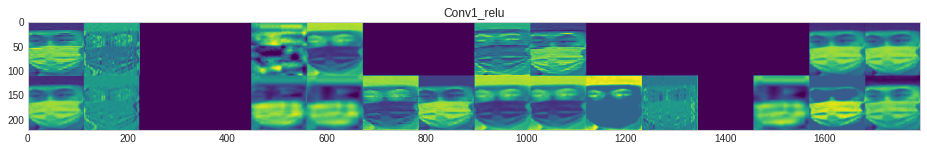

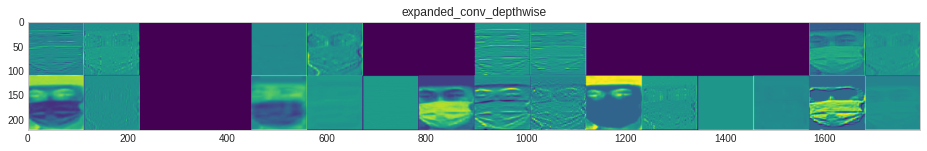

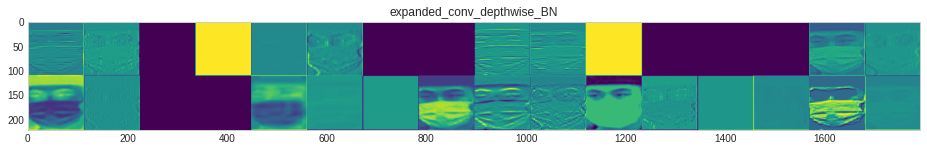

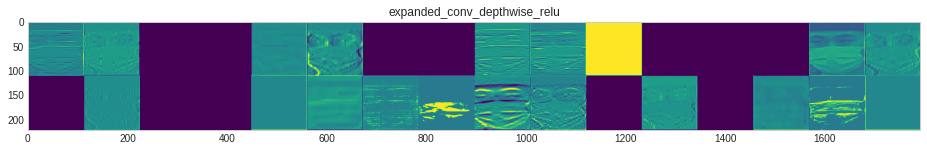

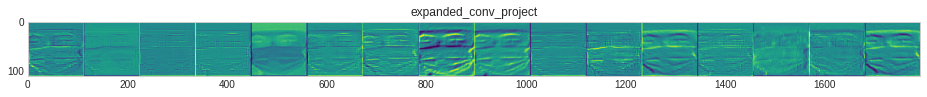

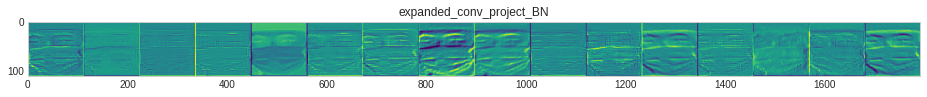

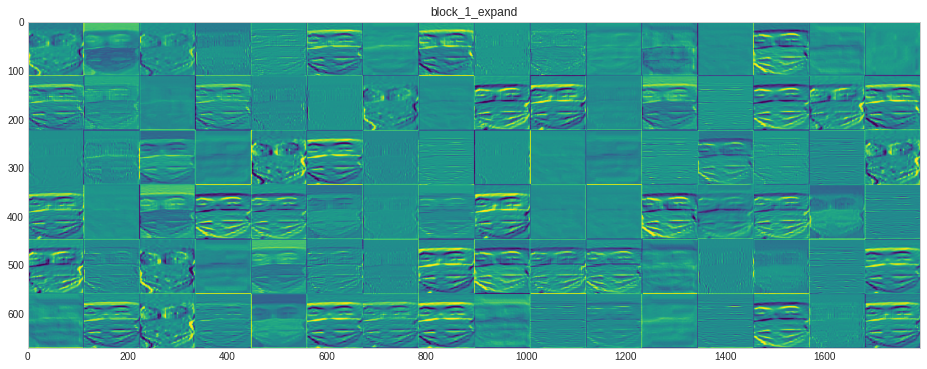

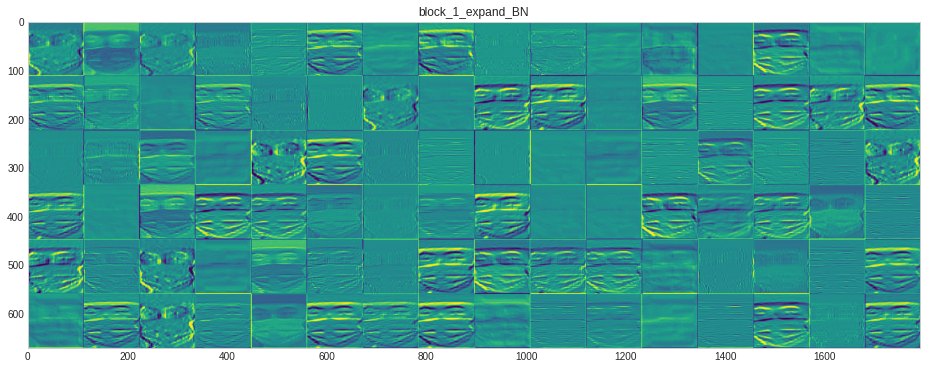

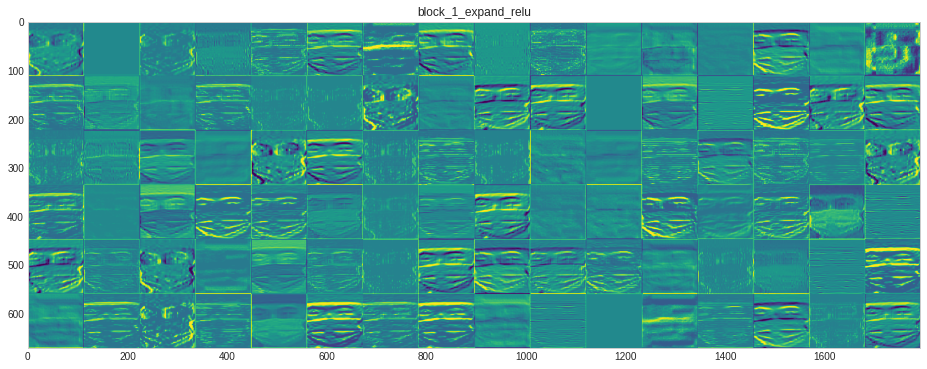

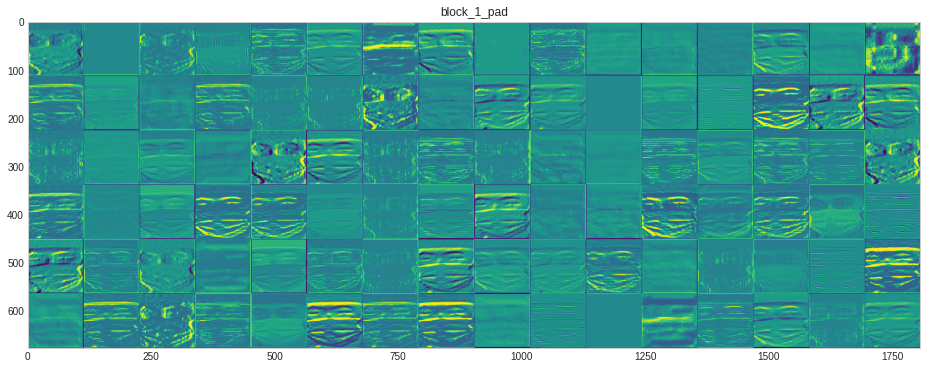

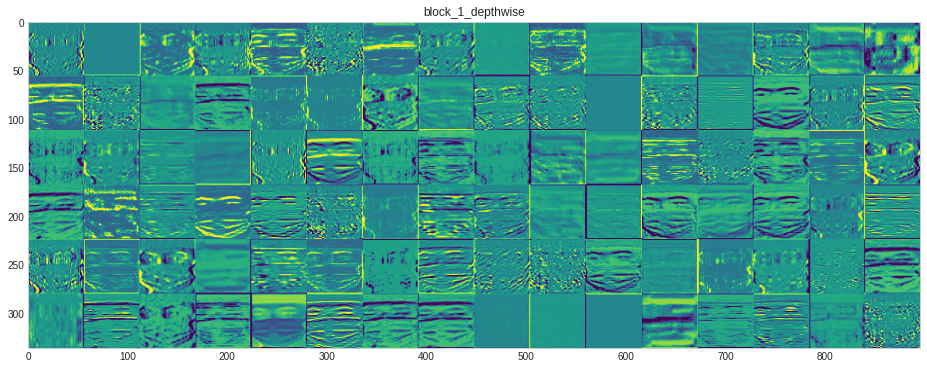

In [ ]:
# src https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md
l1, l2=1,-5
layer_outputs = [layer.output for layer in model.layers[l1:l2]] # Extracts the outputs of the top 12 layers
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img) # Returns a list of five Numpy arrays: one array per layer activation
# print(img.shape)

layer_names = []
for layer in model.layers[l1:l2]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    if n_cols <1:
        continue
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    #print(size, n_cols, display_grid.shape)
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)


    plt.imshow(display_grid, aspect='auto', cmap='viridis')